Drones compromis (Trust Score < 0.5): [0 1 2 3 5]

Métriques d'évaluation :
              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98       933
    Anomalie       0.76      0.76      0.76        67

    accuracy                           0.97      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.97      0.97      0.97      1000

Matrice de confusion :
[[917  16]
 [ 16  51]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: Undefine

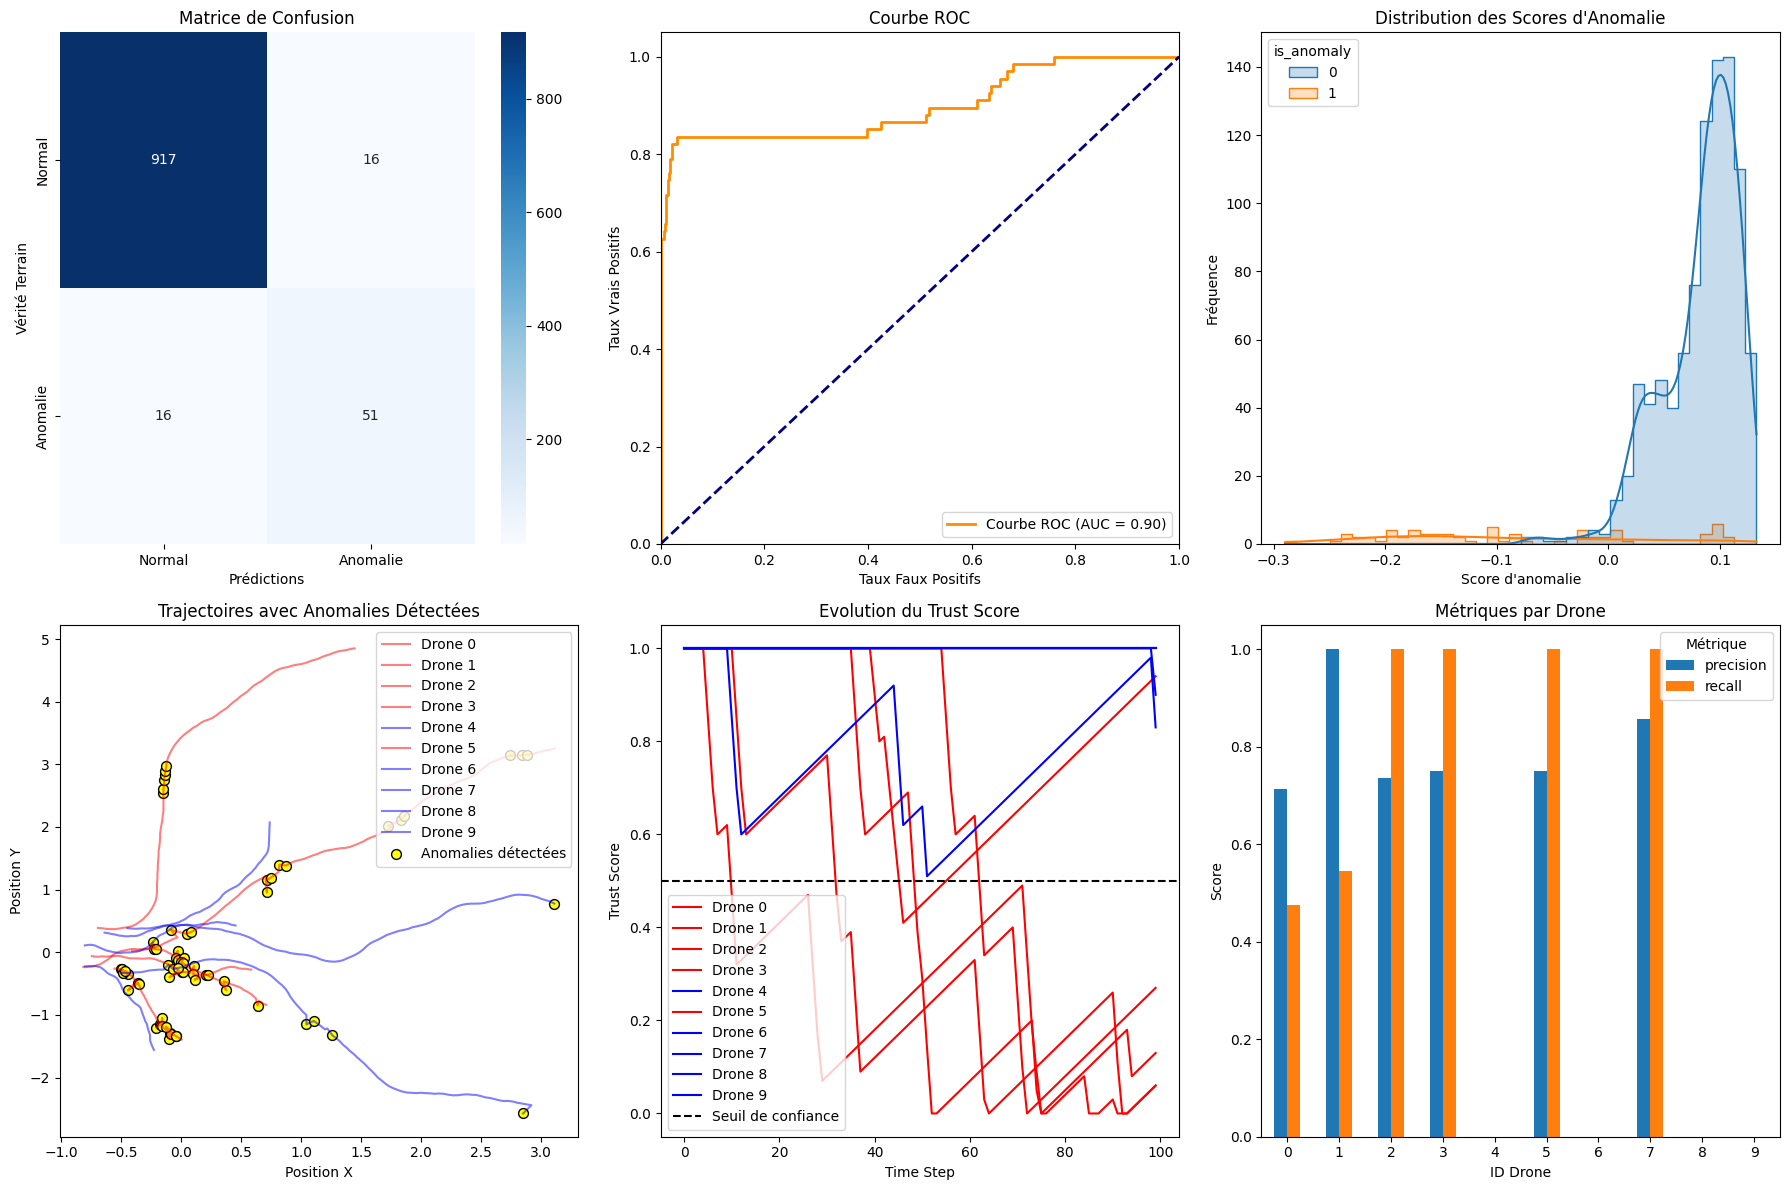

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (classification_report,
                           confusion_matrix,
                           precision_score,
                           recall_score,
                           roc_curve,
                           auc)

# =============================
# 1. Génération du dataset
# =============================

num_drones = 10
num_points = 100
speed_range = (1, 10)
altitude_range = (50, 200)
anomaly_prob = 0.05

def generate_normal_trajectory(start_pos, num_points, speed_range, altitude_range):
    x, y, z = [start_pos[0]], [start_pos[1]], [start_pos[2]]
    speed = np.random.uniform(*speed_range)
    angle = 0

    for _ in range(num_points - 1):
        angle += np.random.uniform(-10, 10)
        angle = np.clip(angle, -90, 90)
        dx = speed * np.cos(np.radians(angle))
        dy = speed * np.sin(np.radians(angle))
        dz = np.random.uniform(-1, 1)
        x.append(x[-1] + dx)
        y.append(y[-1] + dy)
        z.append(np.clip(z[-1] + dz, *altitude_range))
    return np.array(x), np.array(y), np.array(z)

def introduce_anomalies(x, y, z, anomaly_prob):
    for i in range(1, len(x) - 1):
        if np.random.rand() < anomaly_prob:
            x[i + 1] = x[i] + np.random.uniform(-20, 20)
            y[i + 1] = y[i] + np.random.uniform(-20, 20)
            z[i + 1] = z[i] + np.random.uniform(-50, 50)
    return x, y, z

data = []
for drone_id in range(num_drones):
    start_pos = (np.random.uniform(0, 100), np.random.uniform(0, 100), np.random.uniform(50, 200))
    x, y, z = generate_normal_trajectory(start_pos, num_points, speed_range, altitude_range)

    if np.random.rand() < 0.5:
        x, y, z = introduce_anomalies(x, y, z, anomaly_prob)

    for t in range(num_points):
        if t == 0:
            dx = dy = dz = speed = direction = 0
        else:
            dx = x[t] - x[t-1]
            dy = y[t] - y[t-1]
            dz = z[t] - z[t-1]
            speed = np.sqrt(dx**2 + dy**2 + dz**2)
            direction = np.degrees(np.arctan2(dy, dx))
        data.append({
            'drone_id': drone_id,
            'time_step': t,
            'x': x[t],
            'y': y[t],
            'z': z[t],
            'delta_x': dx,
            'delta_y': dy,
            'delta_z': dz,
            'speed': speed,
            'acceleration': speed - data[-1]['speed'] if t > 1 else 0,
            'direction': direction,
            'is_anomaly': int(any([abs(dx) > 10, abs(dy) > 10, abs(dz) > 10])) if t > 0 else 0
        })

df = pd.DataFrame(data)

# =============================
# 2. Simulation d'attaques
# =============================

def simulate_gps_spoofing(df, drone_id, start_time, end_time, spoofing_offset):
    mask = (df['drone_id'] == drone_id) & (df['time_step'] >= start_time) & (df['time_step'] <= end_time)
    df.loc[mask, ['x', 'y', 'z']] += spoofing_offset
    df.loc[mask, 'is_anomaly'] = 1

def simulate_jamming(df, drone_id, start_time, end_time, intensity):
    mask = (df['drone_id'] == drone_id) & (df['time_step'] >= start_time) & (df['time_step'] <= end_time)
    df.loc[mask, 'speed'] = np.random.uniform(0, intensity, size=mask.sum())
    df.loc[mask, 'acceleration'] = 0
    df.loc[mask, 'is_anomaly'] = 1

simulate_gps_spoofing(df, drone_id=0, start_time=20, end_time=30, spoofing_offset=(15, 15, 0))
simulate_jamming(df, drone_id=1, start_time=40, end_time=50, intensity=5)

# =============================
# 3. Prétraitement & Features
# =============================

features = ['x', 'y', 'z', 'delta_x', 'delta_y', 'delta_z', 'speed', 'acceleration', 'direction']
scaler = RobustScaler()
df[features] = scaler.fit_transform(df[features])

# =============================
# 4. Modèle de détection
# =============================

X = df[features]
contamination_rate = df['is_anomaly'].mean()
model = IsolationForest(contamination=contamination_rate, random_state=42)

# D'abord entraîner le modèle
model.fit(X)  # Cette ligne était manquante

# Ensuite calculer les scores et prédictions
df['anomaly_score'] = model.decision_function(X)  # Score de confiance continu
df['is_anomaly_pred'] = model.predict(X)
df['is_anomaly_pred'] = df['is_anomaly_pred'].map({1: 0, -1: 1})  # 0=normal, 1=anomalie

# =============================
# 5. Système de Trust Score
# =============================

# Paramètres du Trust Score
INITIAL_TRUST_SCORE = 1.0
TRUST_THRESHOLD = 0.5
PENALTIES = {
    'mouvement_anormal': -0.1,
    'spoofing_detecte': -0.3,
    'jamming_detecte': -0.2,
    'variation_altitude': -0.15
}
REWARD = 0.01  # Récompense pour comportement normal

# Initialisation du Trust Score
df['trust_score'] = INITIAL_TRUST_SCORE

# Mise à jour du Trust Score
for drone_id in df['drone_id'].unique():
    drone_data = df[df['drone_id'] == drone_id].copy()
    trust_score = INITIAL_TRUST_SCORE

    for i in range(1, len(drone_data)):
        current = drone_data.iloc[i]
        previous = drone_data.iloc[i-1]

        # Récompenser le comportement normal
        if current['is_anomaly_pred'] == 0:
            trust_score = min(trust_score + REWARD, 1.0)

        # Appliquer les pénalités pour anomalies
        if current['is_anomaly_pred'] == 1:
            # Détecter le type d'anomalie
            if abs(current['delta_z']) > 2:
                penalty = PENALTIES['variation_altitude']
            elif current['speed'] > 3 or current['acceleration'] > 1.5:
                penalty = PENALTIES['mouvement_anormal']
            else:
                penalty = PENALTIES['mouvement_anormal']

            trust_score = max(trust_score + penalty, 0)

        df.loc[(df['drone_id'] == drone_id) & (df['time_step'] == current['time_step']), 'trust_score'] = trust_score

# Identifier les drones compromis
compromised_drones = df[df['trust_score'] < TRUST_THRESHOLD]['drone_id'].unique()
print(f"Drones compromis (Trust Score < {TRUST_THRESHOLD}): {compromised_drones}")

# Marquer les points en quarantaine
df['is_quarantined'] = df['drone_id'].isin(compromised_drones)

# =============================
# 6. Évaluation
# =============================

y_true = df['is_anomaly']
y_pred = df['is_anomaly_pred']

print("\nMétriques d'évaluation :")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Anomalie']))
print("Matrice de confusion :")
print(confusion_matrix(y_true, y_pred))

# =============================
# 7. Visualisation améliorée
# =============================

plt.figure(figsize=(18, 12))

# 1. Matrice de confusion
plt.subplot(2, 3, 1)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Anomalie'],
            yticklabels=['Normal', 'Anomalie'])
plt.title('Matrice de Confusion')
plt.ylabel('Vérité Terrain')
plt.xlabel('Prédictions')

# 2. Courbe ROC (si vous voulez convertir en probabilités)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_true, -df['anomaly_score'])  # Note: -score car IsolationForest
roc_auc = auc(fpr, tpr)
plt.subplot(2, 3, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux Faux Positifs')
plt.ylabel('Taux Vrais Positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")

# 3. Distribution des scores d'anomalie
plt.subplot(2, 3, 3)
sns.histplot(data=df, x='anomaly_score', hue='is_anomaly', element='step', kde=True)
plt.title('Distribution des Scores d\'Anomalie')
plt.xlabel('Score d\'anomalie')
plt.ylabel('Fréquence')

# 4. Trajectoires avec anomalies
plt.subplot(2, 3, 4)
for drone_id in df['drone_id'].unique():
    drone_data = df[df['drone_id'] == drone_id]
    color = 'red' if drone_id in compromised_drones else 'blue'
    plt.plot(drone_data['x'], drone_data['y'], color=color, alpha=0.5, label=f'Drone {drone_id}')

# Marquer les points détectés comme anomalies
anomalies = df[df['is_anomaly_pred'] == 1]
plt.scatter(anomalies['x'], anomalies['y'], color='yellow', s=50, edgecolor='black', label='Anomalies détectées')
plt.title('Trajectoires avec Anomalies Détectées')
plt.xlabel('Position X')
plt.ylabel('Position Y')
plt.legend()

# 5. Evolution du Trust Score
plt.subplot(2, 3, 5)
for drone_id in df['drone_id'].unique():
    drone_data = df[df['drone_id'] == drone_id]
    color = 'red' if drone_id in compromised_drones else 'blue'
    plt.plot(drone_data['time_step'], drone_data['trust_score'], color=color, label=f'Drone {drone_id}')
plt.axhline(y=TRUST_THRESHOLD, color='black', linestyle='--', label='Seuil de confiance')
plt.title('Evolution du Trust Score')
plt.xlabel('Time Step')
plt.ylabel('Trust Score')
plt.legend()

# 6. Comparaison des métriques par drone
plt.subplot(2, 3, 6)
drone_metrics = []
for drone_id in df['drone_id'].unique():
    subset = df[df['drone_id'] == drone_id]
    precision = precision_score(subset['is_anomaly'], subset['is_anomaly_pred'])
    recall = recall_score(subset['is_anomaly'], subset['is_anomaly_pred'])
    drone_metrics.append({'drone_id': drone_id, 'precision': precision, 'recall': recall})

metrics_df = pd.DataFrame(drone_metrics)
metrics_df.plot(x='drone_id', y=['precision', 'recall'], kind='bar', ax=plt.gca())
plt.title('Métriques par Drone')
plt.xlabel('ID Drone')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(title='Métrique')

plt.tight_layout()
plt.show()

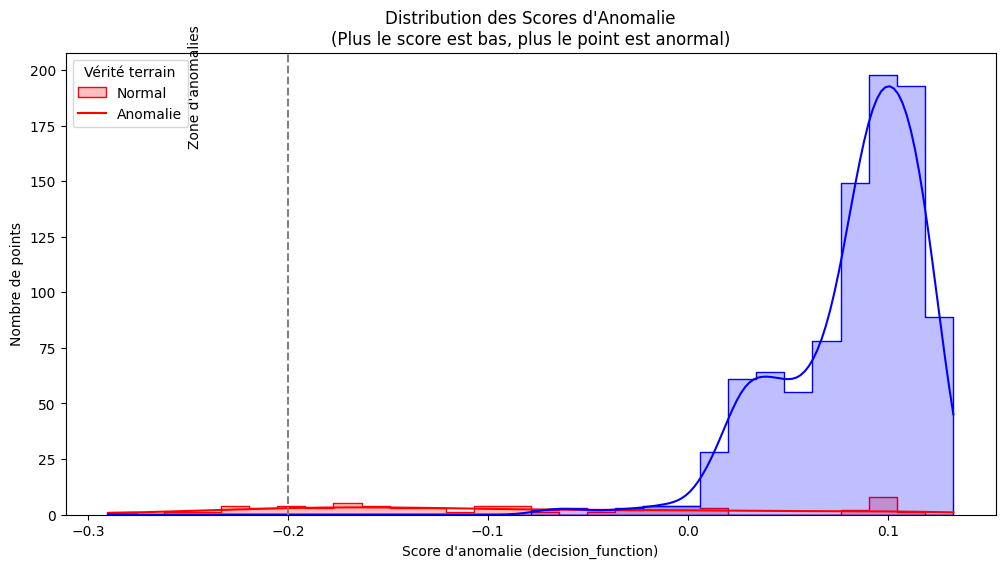

In [ ]:
plt.figure(figsize=(12, 6))
ax = sns.histplot(data=df, x='anomaly_score', hue='is_anomaly',
                 element='step', kde=True, bins=30,
                 palette={0: "blue", 1: "red"})

# Ajout d'annotations
plt.axvline(x=-0.2, color='gray', linestyle='--', label='Seuil potentiel')
plt.text(-0.25, 0.8*ax.get_ylim()[1], 'Zone d\'anomalies', rotation=90)
plt.legend(title='Vérité terrain', labels=['Normal', 'Anomalie'])

plt.title('Distribution des Scores d\'Anomalie\n(Plus le score est bas, plus le point est anormal)')
plt.xlabel('Score d\'anomalie (decision_function)')
plt.ylabel('Nombre de points')
plt.show()

In [ ]:
nombre_drones = df['drone_id'].nunique()
print(f"Il y a {nombre_drones} drones dans le dataset")

Il y a 10 drones dans le dataset


=== MATRICE DE CONFUSION GLOBALE ===
          Normal    Anomalie  
          --------------------
Normal    2145      34        
Anomalie  34        37        

=== MATRICES PAR TYPE D'ATTAQUE ===

Attaque: RANDOM_ANOMALY
          Normal    Anomalie  
          --------------------
Normal    2145      34        
Anomalie  2         36        


Attaque: GPS_SPOOFING
          Normal    Anomalie  
          --------------------
Normal    0         0         
Anomalie  11        0         


Attaque: JAMMING
          Normal    Anomalie  
          --------------------
Normal    0         0         
Anomalie  11        0         


Attaque: HI_JACK
          Normal    Anomalie  
          --------------------
Normal    0         0         
Anomalie  10        1         

